In [1]:
import numpy as np
import dataloaders
import os
import pandas as pd
#from skimage import morphology
import inference
from inference import plot_training
import matplotlib.pyplot as plt
from icecream import ic

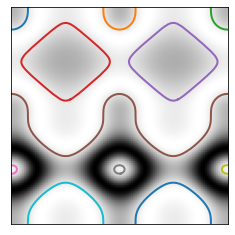

In [12]:
from skimage import measure
import cv2

# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp(np.sin(x)**3 + np.cos(y)**2))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

(300, 300)


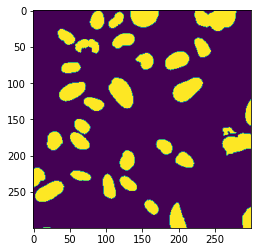

In [37]:
i = 20

pc = test_masks[i, :300, :300].squeeze()
print(pc.shape)
plt.imshow(pc)

In [15]:
pc.shape

(300, 300)

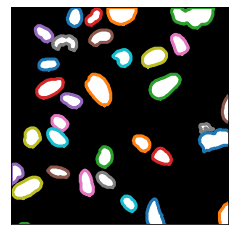

In [38]:
contours = measure.find_contours(pc, level = 0.5)

fig, ax = plt.subplots()
ax.imshow(pc, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=3)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

arr.shape=(300, 300)  arr.max()=0   arr.min()=0  arr.mean()=0.0 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.004033333333333333 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.007955555555555556 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.013166666666666667 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.0030666666666666668 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.003522222222222222 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.0048111111111111115 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.004388888888888889 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0.004677777777777778 arr.dtype=dtype('uint8')
arr.shape=(300, 300)  arr.max()=1   arr.min()=0  arr.mean()=0

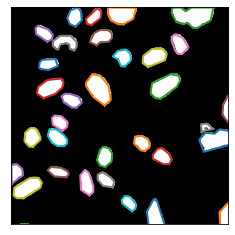

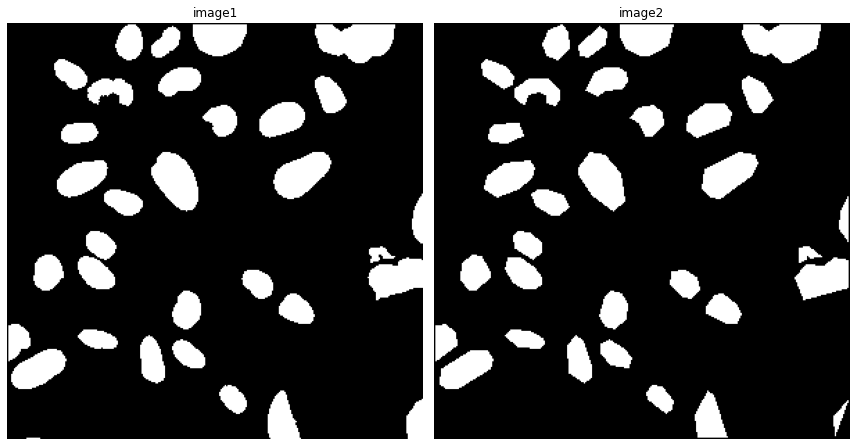

In [45]:
import scipy.ndimage as ndimage 

fig, ax = plt.subplots()
ax.imshow(pc, cmap=plt.cm.gray)

#newmask = np.zeros_like(pc, dtype='bool')
newmask = np.zeros_like(pc)
print_info(newmask)

for contour in contours:
    poly = measure.approximate_polygon(contour, 2) #2 #3.5
    ax.plot(poly[:, 1], poly[:, 0], linewidth=2)
    # Create a contour image by using the contour coordinates rounded to their nearest integer value
    msk = measure.grid_points_in_poly(newmask.shape, poly).astype(np.uint8)
    print_info(msk)
    newmask = newmask + msk


# Fill in the hole created by the contour boundary
#newmask = ndimage.binary_fill_holes(newmask)    
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

inference.show_image_pair(pc, newmask)


In [44]:
print_info(msk)

arr.shape=(300, 300)  arr.max()=0   arr.min()=0  arr.mean()=0.0 arr.dtype=dtype('uint8')


## Preparing polygon dataset

In [2]:
def print_info(arr):
    print(f"{arr.shape=}  {arr.max()=}   {arr.min()=}  {arr.mean()=} {arr.dtype=}")

train_data, train_masks, train_idx = dataloaders.get_7l_data("train")
print_info(train_data)
print_info(train_masks)
print(train_idx.shape, train_idx.dtype)

arr.shape=(2016, 1080, 1080, 1)  arr.max()=255   arr.min()=0  arr.mean()=109.85832324684418 arr.dtype=dtype('uint8')
arr.shape=(2016, 1080, 1080, 1)  arr.max()=1   arr.min()=0  arr.mean()=0.1306028235875683 arr.dtype=dtype('uint8')
(2016,) <U6


In [4]:
#2016/3 = 672
split_point = 672
train_realmasks = train_masks[:split_point]
train_polymasks = train_masks[split_point:2*split_point]
train_coarsemasks = train_masks[-split_point:]
print_info(train_realmasks)
print_info(train_polymasks)
print_info(train_coarsemasks)

arr.shape=(672, 1080, 1080, 1)  arr.max()=1   arr.min()=0  arr.mean()=0.12690672281215298 arr.dtype=dtype('uint8')
arr.shape=(672, 1080, 1080, 1)  arr.max()=1   arr.min()=0  arr.mean()=0.13547026565255732 arr.dtype=dtype('uint8')
arr.shape=(672, 1080, 1080, 1)  arr.max()=1   arr.min()=0  arr.mean()=0.12943148229799464 arr.dtype=dtype('uint8')


In [64]:
from skimage import measure

def poly_proxy(array, tolerance):
    source_array = array.copy().squeeze()
    print_info(source_array)
    result_array = np.zeros_like(source_array)
    for i, mask in enumerate(source_array):
        if i%10 == 0:
            print(f"Processing {i}")
        contours = measure.find_contours(mask, level = 0.5)
        for contour in contours:
            poly = measure.approximate_polygon(contour, tolerance) #2 #3.5
            #ax.plot(poly[:, 1], poly[:, 0], linewidth=2)
            # Create a contour image by using the contour coordinates rounded to their nearest integer value
            msk = measure.grid_points_in_poly(mask.shape, poly).astype(np.uint8)
            #print_info(msk)
            result_array[i] += msk
    result_array = np.expand_dims(result_array, -1)
    return result_array

train_mask_coarsepoly = poly_proxy(train_coarsemasks, 3.5)
print_info(train_mask_coarsepoly)

arr.shape=(672, 1080, 1080)  arr.max()=1   arr.min()=0  arr.mean()=0.12943148229799464 arr.dtype=dtype('uint8')
Processing 0
Processing 10
Processing 20
Processing 30
Processing 40
Processing 50
Processing 60
Processing 70
Processing 80
Processing 90
Processing 100
Processing 110
Processing 120
Processing 130
Processing 140
Processing 150
Processing 160
Processing 170
Processing 180
Processing 190
Processing 200
Processing 210
Processing 220
Processing 230
Processing 240
Processing 250
Processing 260
Processing 270
Processing 280
Processing 290
Processing 300
Processing 310
Processing 320
Processing 330
Processing 340
Processing 350
Processing 360
Processing 370
Processing 380
Processing 390
Processing 400
Processing 410
Processing 420
Processing 430
Processing 440
Processing 450
Processing 460
Processing 470
Processing 480
Processing 490
Processing 500
Processing 510
Processing 520
Processing 530
Processing 540
Processing 550
Processing 560
Processing 570
Processing 580
Processing 590

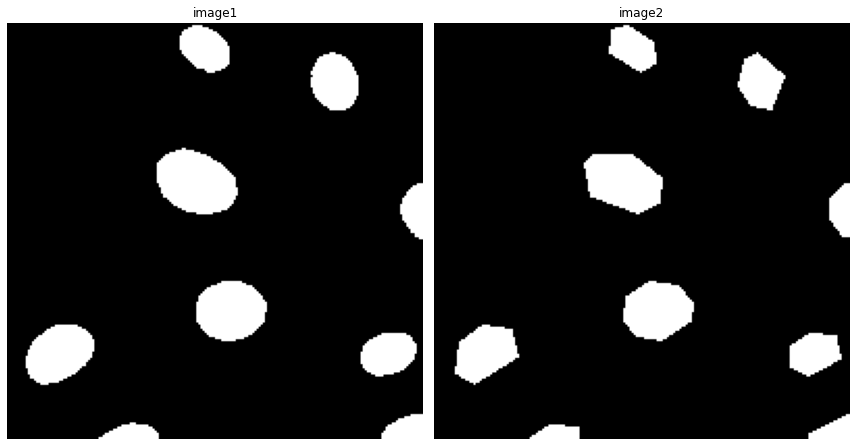

In [68]:
i = 30
inference.show_image_pair(train_coarsemasks[i, :200, :200], train_mask_coarsepoly[i, :200, :200])

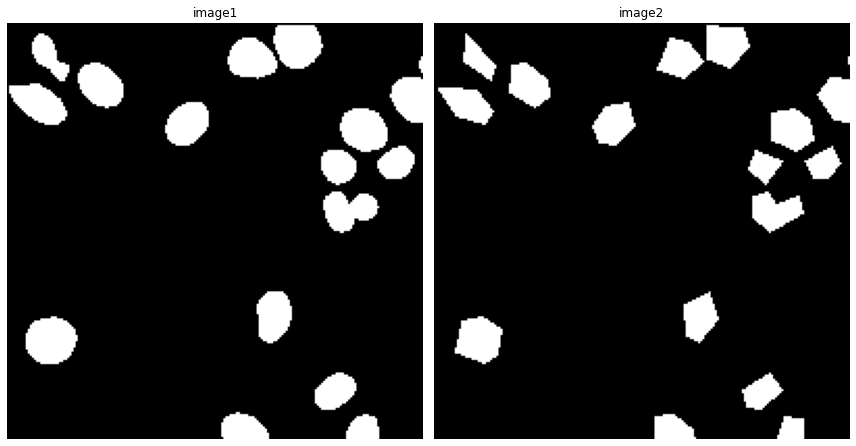

In [61]:
i = 390
inference.show_image_pair(train_polymasks[i, :200, :200], train_mask_finepoly[i, :200, :200])

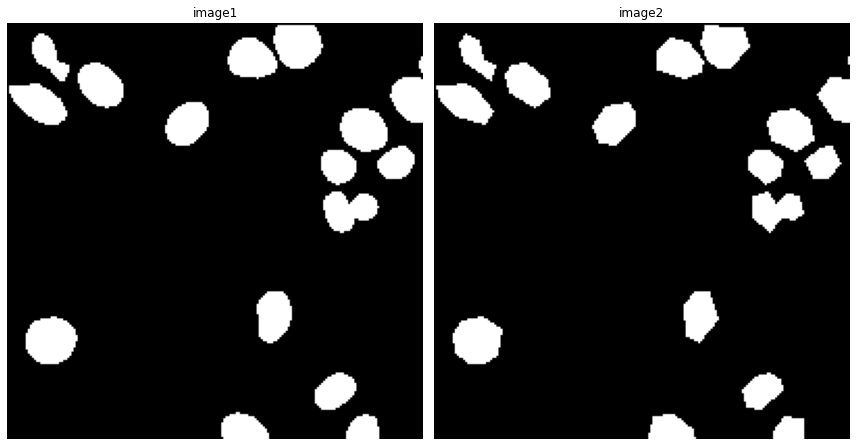

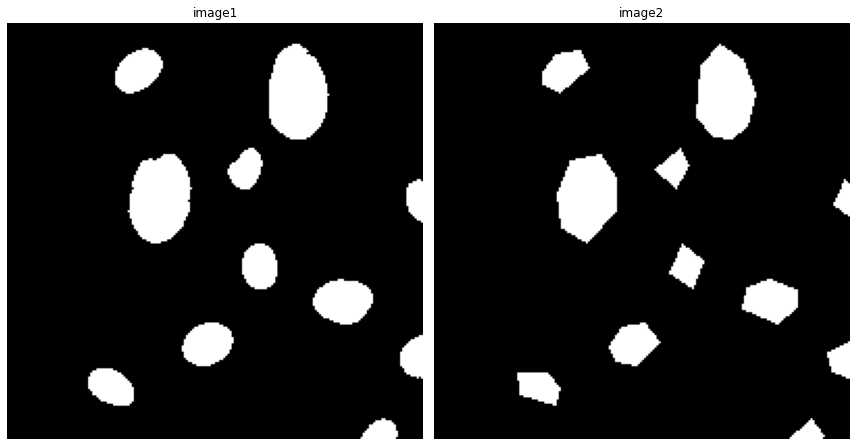

In [71]:
i = 390
inference.show_image_pair(train_polymasks[i, :200, :200], train_mask_finepoly[i, :200, :200])
inference.show_image_pair(train_coarsemasks[i, :200, :200], train_mask_coarsepoly[i, :200, :200])

In [5]:
poly_set = np.concatenate((train_realmasks, train_mask_finepoly, train_mask_coarsepoly))
print_info(poly_set)

arr.shape=(2016, 1080, 1080, 1)  arr.max()=2   arr.min()=0  arr.mean()=0.12087771890377665 arr.dtype=dtype('uint8')


In [3]:
poly_set = (poly_set > 0).astype(np.uint8)
print_info(poly_set)

arr.shape=(2016, 1080, 1080, 1)  arr.max()=1   arr.min()=0  arr.mean()=0.12087608502691771 arr.dtype=dtype('uint8')


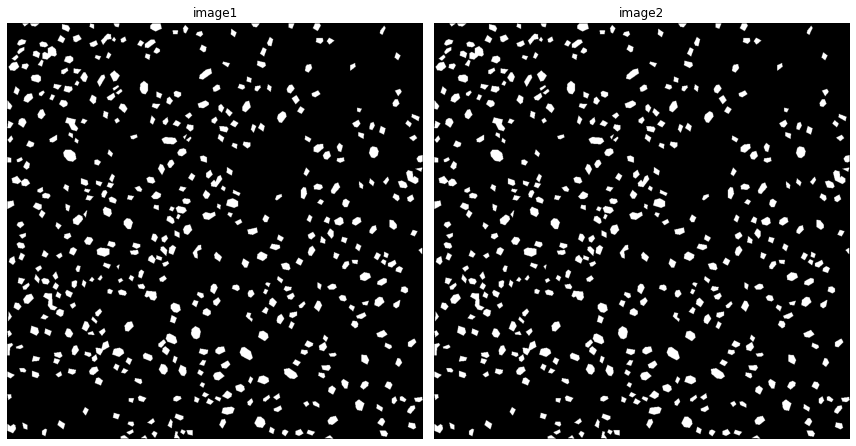

In [6]:
i = 700 + 672
inference.show_image_pair(poly_set[i], poly_set[i])

## Altogether

In [9]:
dataloaders.create_polygon_map()

{'REAL': array([1., 0., 0.]),
 'FINE': array([0., 1., 0.]),
 'COARSE': array([0., 0., 1.])}

IndexError: index 2016 is out of bounds for axis 0 with size 2016

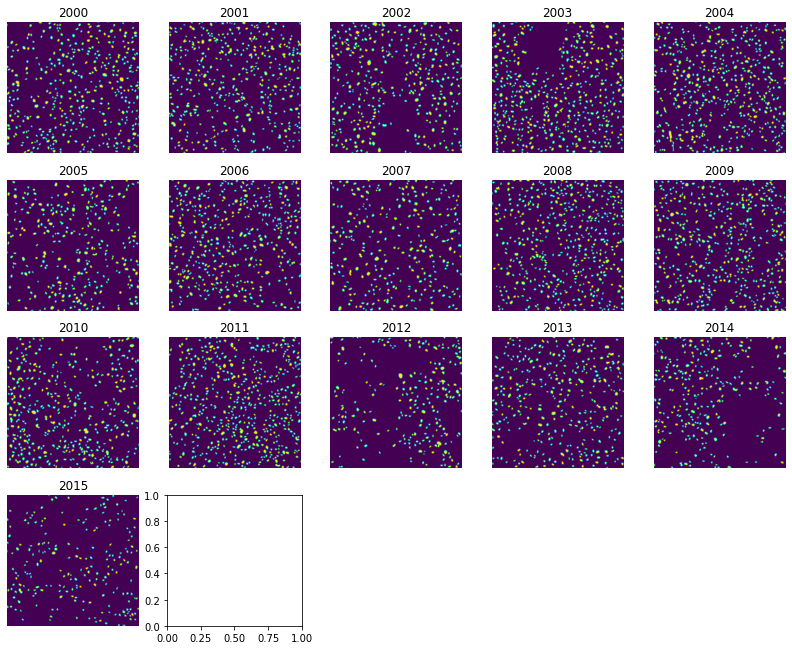

In [33]:
plt.rcParams['figure.figsize'] = (14.0, 14.0)
t=2000
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(poly_masks_set[t+i])
    plt.title(str(t+i))
    plt.axis('off')
    
plt.show()

plt.rcParams['figure.figsize'] = (14.0, 14.0)
t+=25
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(poly_masks_set[t+i])
    plt.title(str(t+i))
    plt.axis('off')
    
plt.show()


plt.rcParams['figure.figsize'] = (14.0, 14.0)
t+=25
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(poly_masks_set[t+i])
    plt.title(str(t+i))
    plt.axis('off')
    
plt.show()


plt.rcParams['figure.figsize'] = (14.0, 14.0)
t+=25
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(poly_masks_set[t+i])
    plt.title(str(t+i))
    plt.axis('off')
    
plt.show()



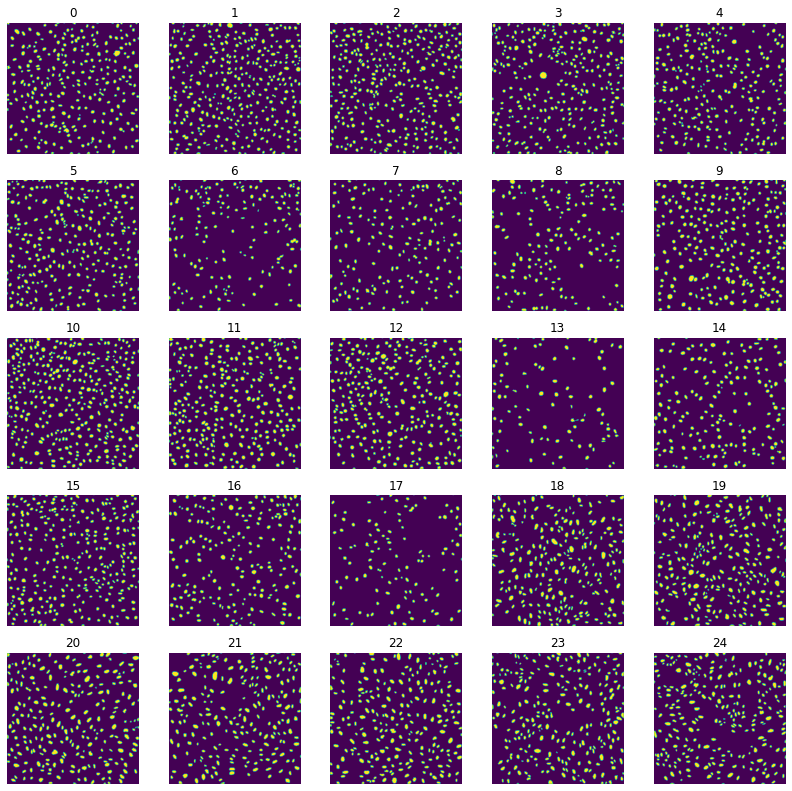

In [3]:
plt.rcParams['figure.figsize'] = (14.0, 14.0)
t=0
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_masks[t+i])
    plt.title(str(t+i))
    plt.axis('off')
    
plt.show()